<a href="https://colab.research.google.com/github/shanaam/teamA-grebes-NMA2020/blob/master/SM/200723_sm_nma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
#@title Data retrieval amd loading
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [68]:
# import packages
from scipy.io import loadmat
import os, fnmatch
from google.colab import drive
from google.colab import files
import math
import os, requests
import pandas as pd
import scipy.stats as st

import matplotlib.pyplot as plt

plt.style.use('dark_background')

plt.rcParams['figure.figsize'] = [20, 6]
plt.rcParams['font.size'] =15
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.autolayout'] = True

%config InlineBackend.figure_format = 'retina'

In [69]:
# mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
print(dat['sresp'].shape)
print(len(dat['stat']))
print((dat['stat'][19].dtype))
print(dat['stat'][19]['med'])

(11983, 7018)
11983
[('ipix', 'O'), ('ypix', 'O'), ('xpix', 'O'), ('lam', 'O'), ('lambda', 'O'), ('npix', 'O'), ('med', 'O'), ('neuropilCoefficient', 'O'), ('baseline', 'O'), ('footprint', 'O'), ('mrs', 'O'), ('mrs0', 'O'), ('cmpct', 'O'), ('aspect_ratio', 'O'), ('ellipse', 'O'), ('mimgProj', 'O'), ('mimgProjAbs', 'O'), ('isoverlap', 'O'), ('radius', 'O'), ('ipix_neuropil', 'O'), ('dFstat', 'O'), ('skew', 'O'), ('std', 'O'), ('maxMinusMed', 'O'), ('top5pcMinusMed', 'O'), ('blockstarts', 'O'), ('iplane', 'O'), ('iscell', 'O'), ('noiseLevel', 'O')]
[array([[191.5,  23. ]])]


In [71]:
num_cells,num_times = dat['sresp'].shape
run = np.squeeze(dat['run'])
sresp = dat['sresp']

[Text(0, 0.5, 'Ca2+ Activity'), Text(0.5, 0, 'Time')]

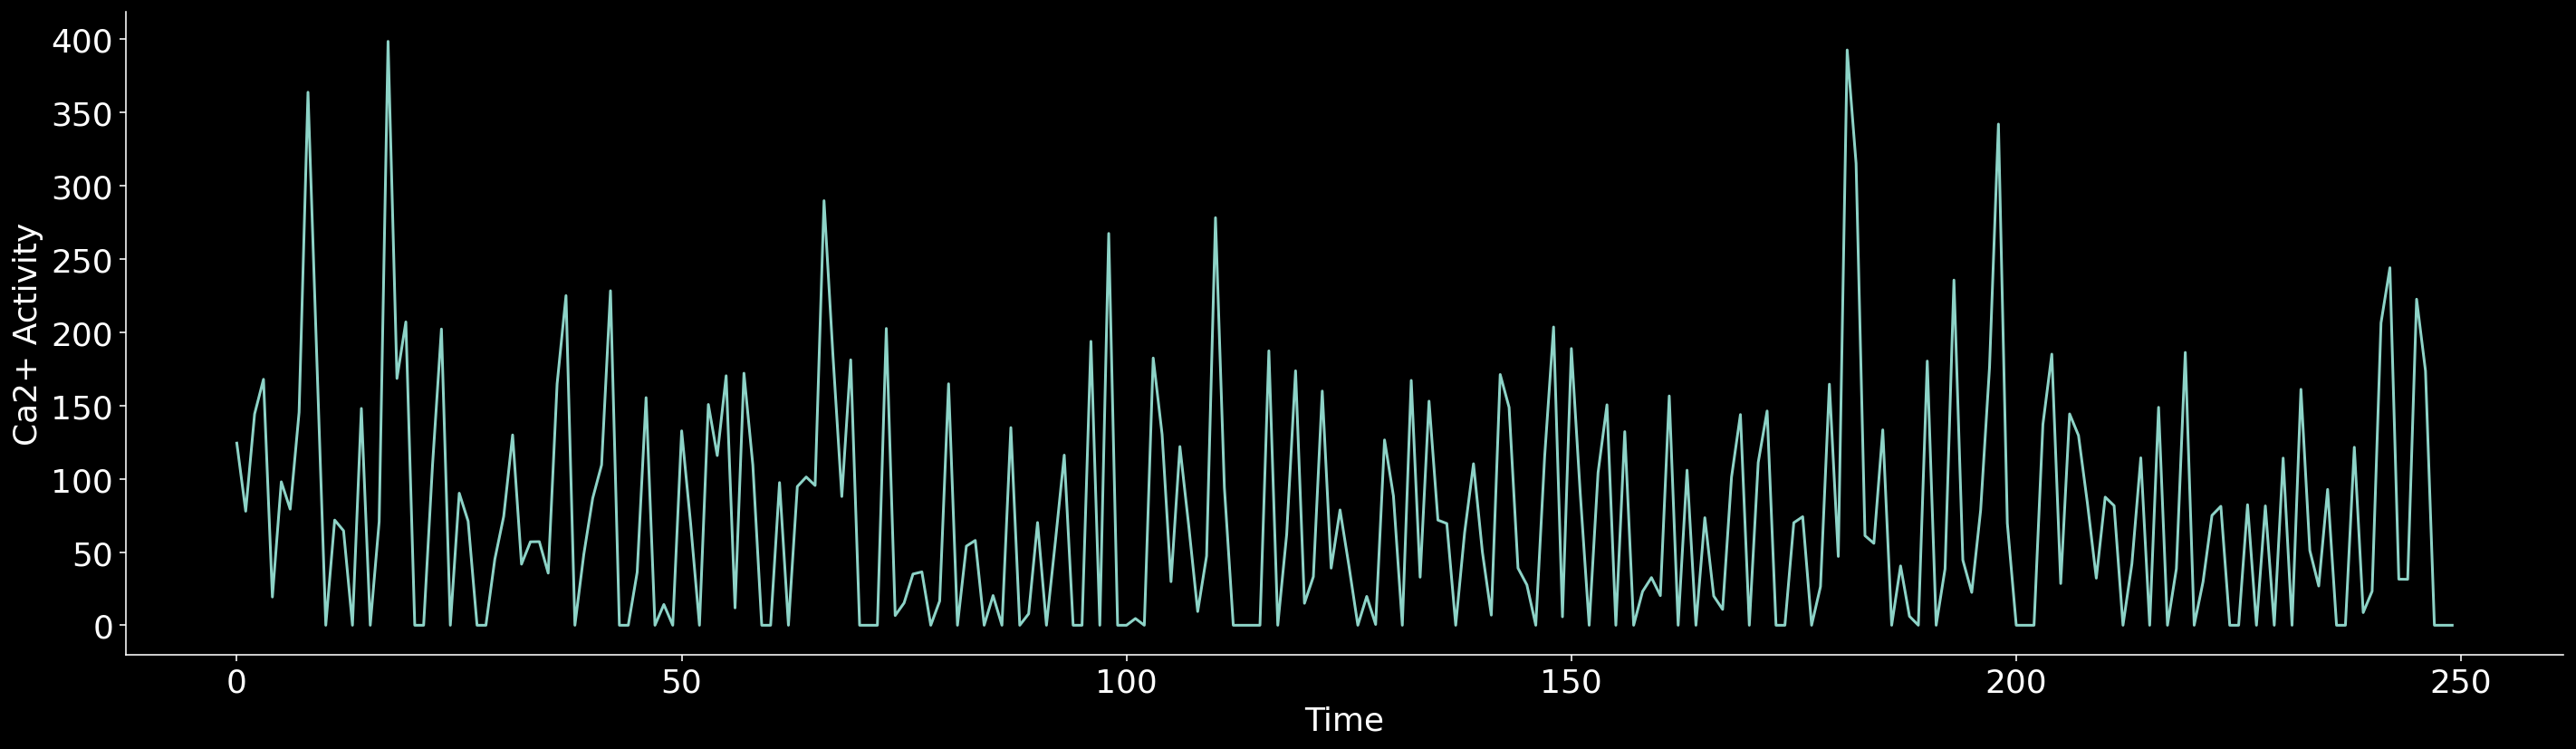

In [72]:
neuron_idx = 134
stop_len = 250
plt.plot(sresp[neuron_idx,:stop_len])
ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Ca2+ Activity",
)

[Text(0, 0.5, 'Running Speed [a.u.]'), Text(0.5, 0, 'Time')]

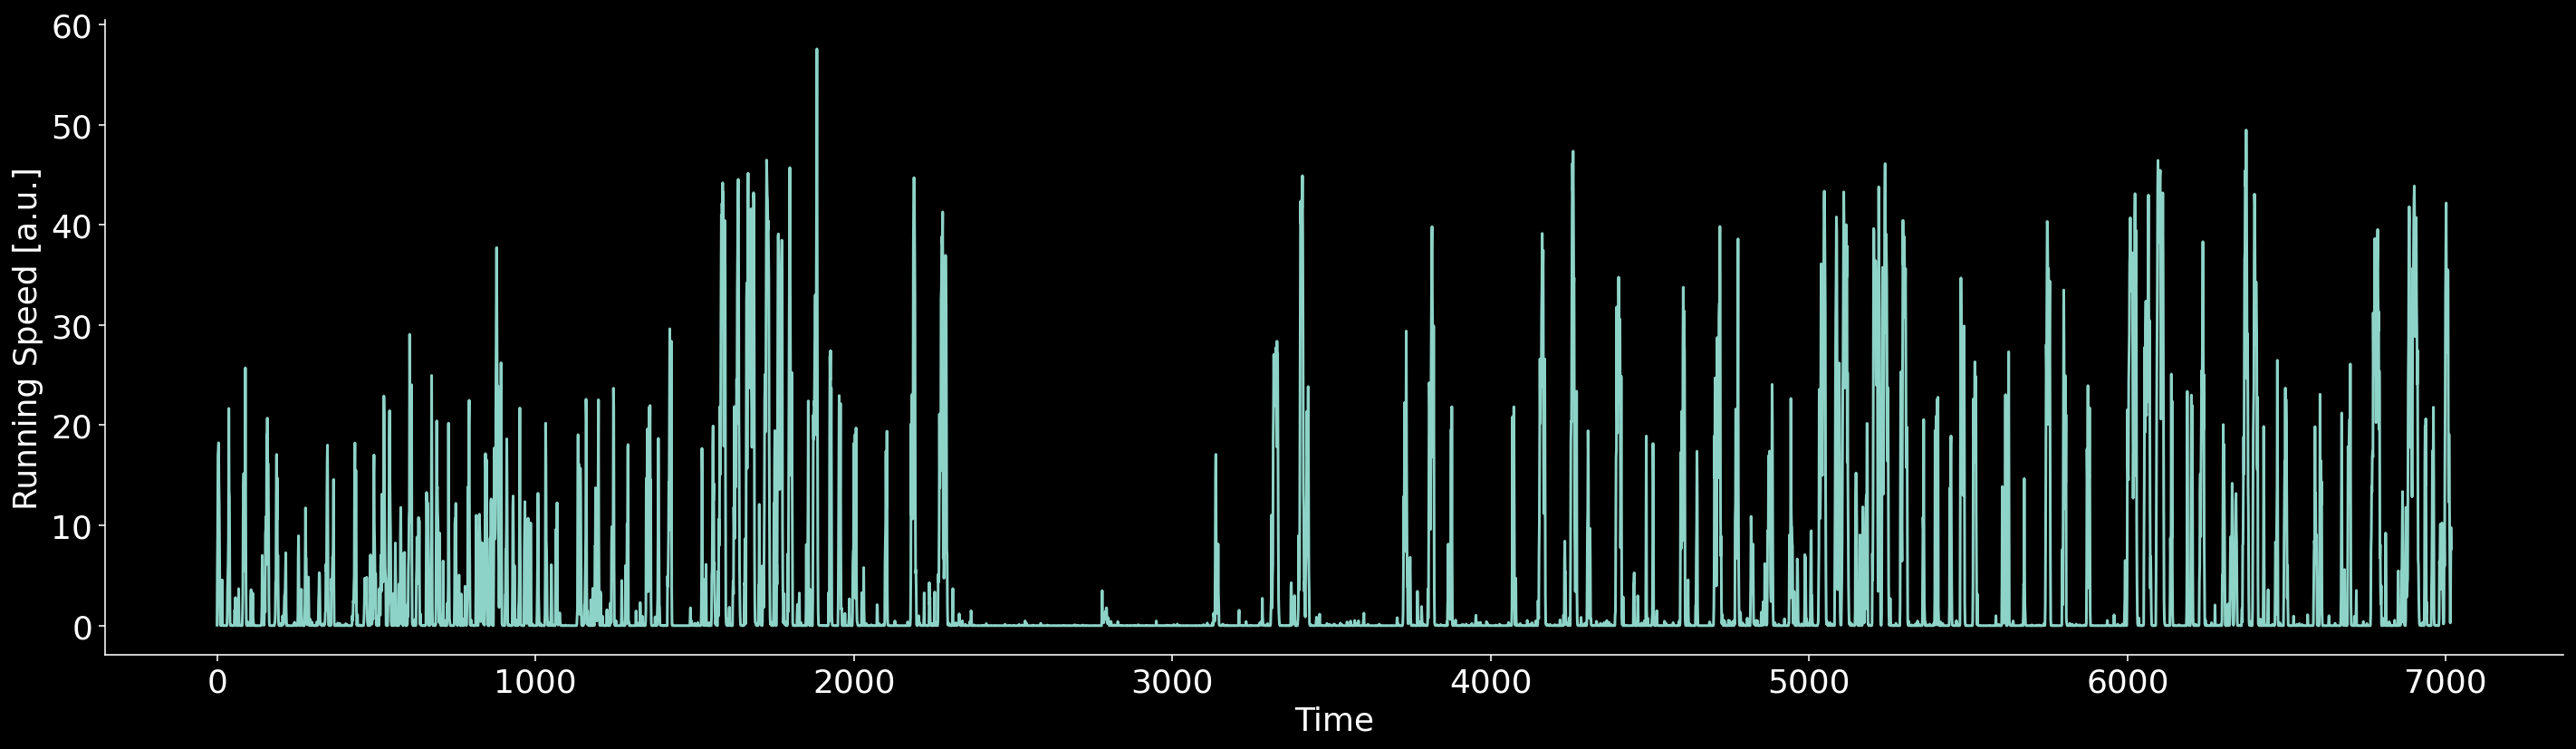

In [73]:
plt.plot(run[:])
ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Running Speed [a.u.]",
)

## serialize running speed

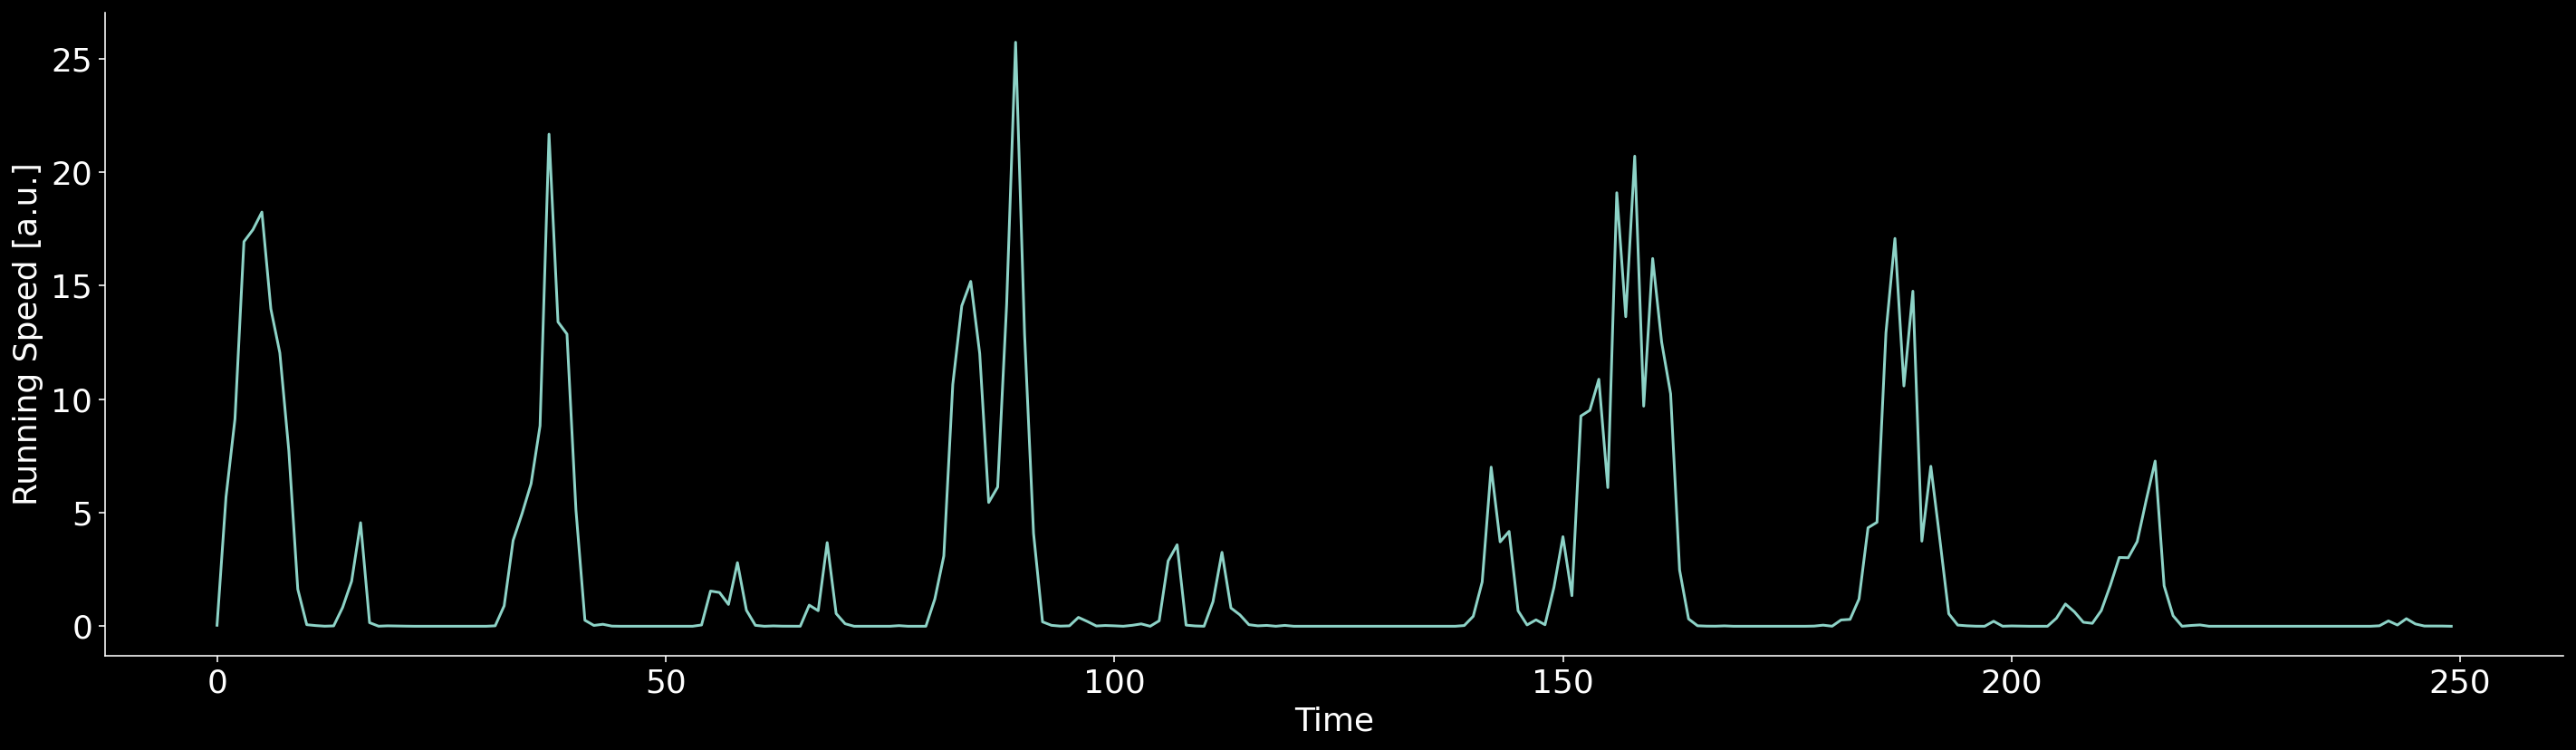

In [74]:
plt.plot(run[:stop_len])

t = np.arange(stop_len)

ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Running Speed [a.u.]",
)
plt.show()

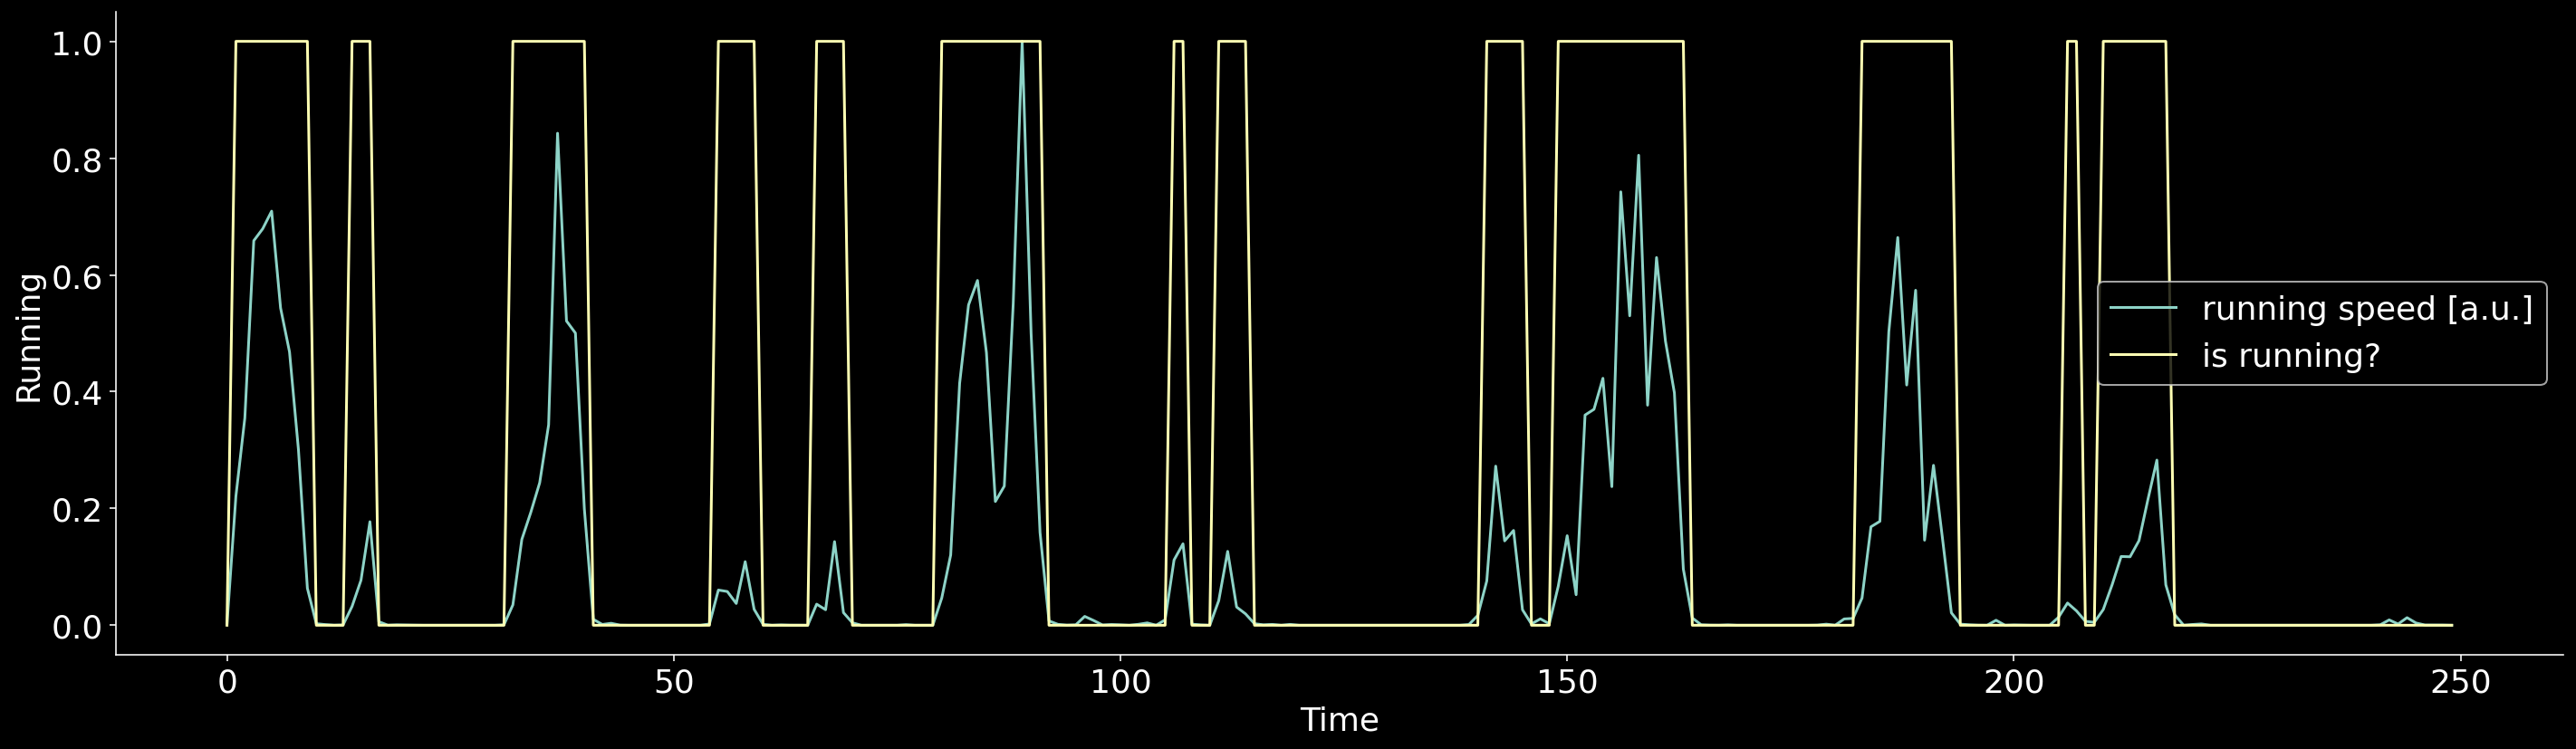

In [75]:
run_thres = 0.5 #cut-off threhold for running speed to be considered running [a.u.]

#function to detm if running
def is_running(x):
  if x >= run_thres:
    return 1
  else:
    return 0

# map the above funtion to our run
is_run = np.array([is_running(xi) for xi in run])

#plot
plt.plot(run[:stop_len]/ max(run[:stop_len]), label = "running speed [a.u.]")
plt.plot(is_run[:stop_len], label = "is running?")
plt.xlabel("Time")
plt.ylabel("Running")
plt.legend()
plt.show()

## index starting points

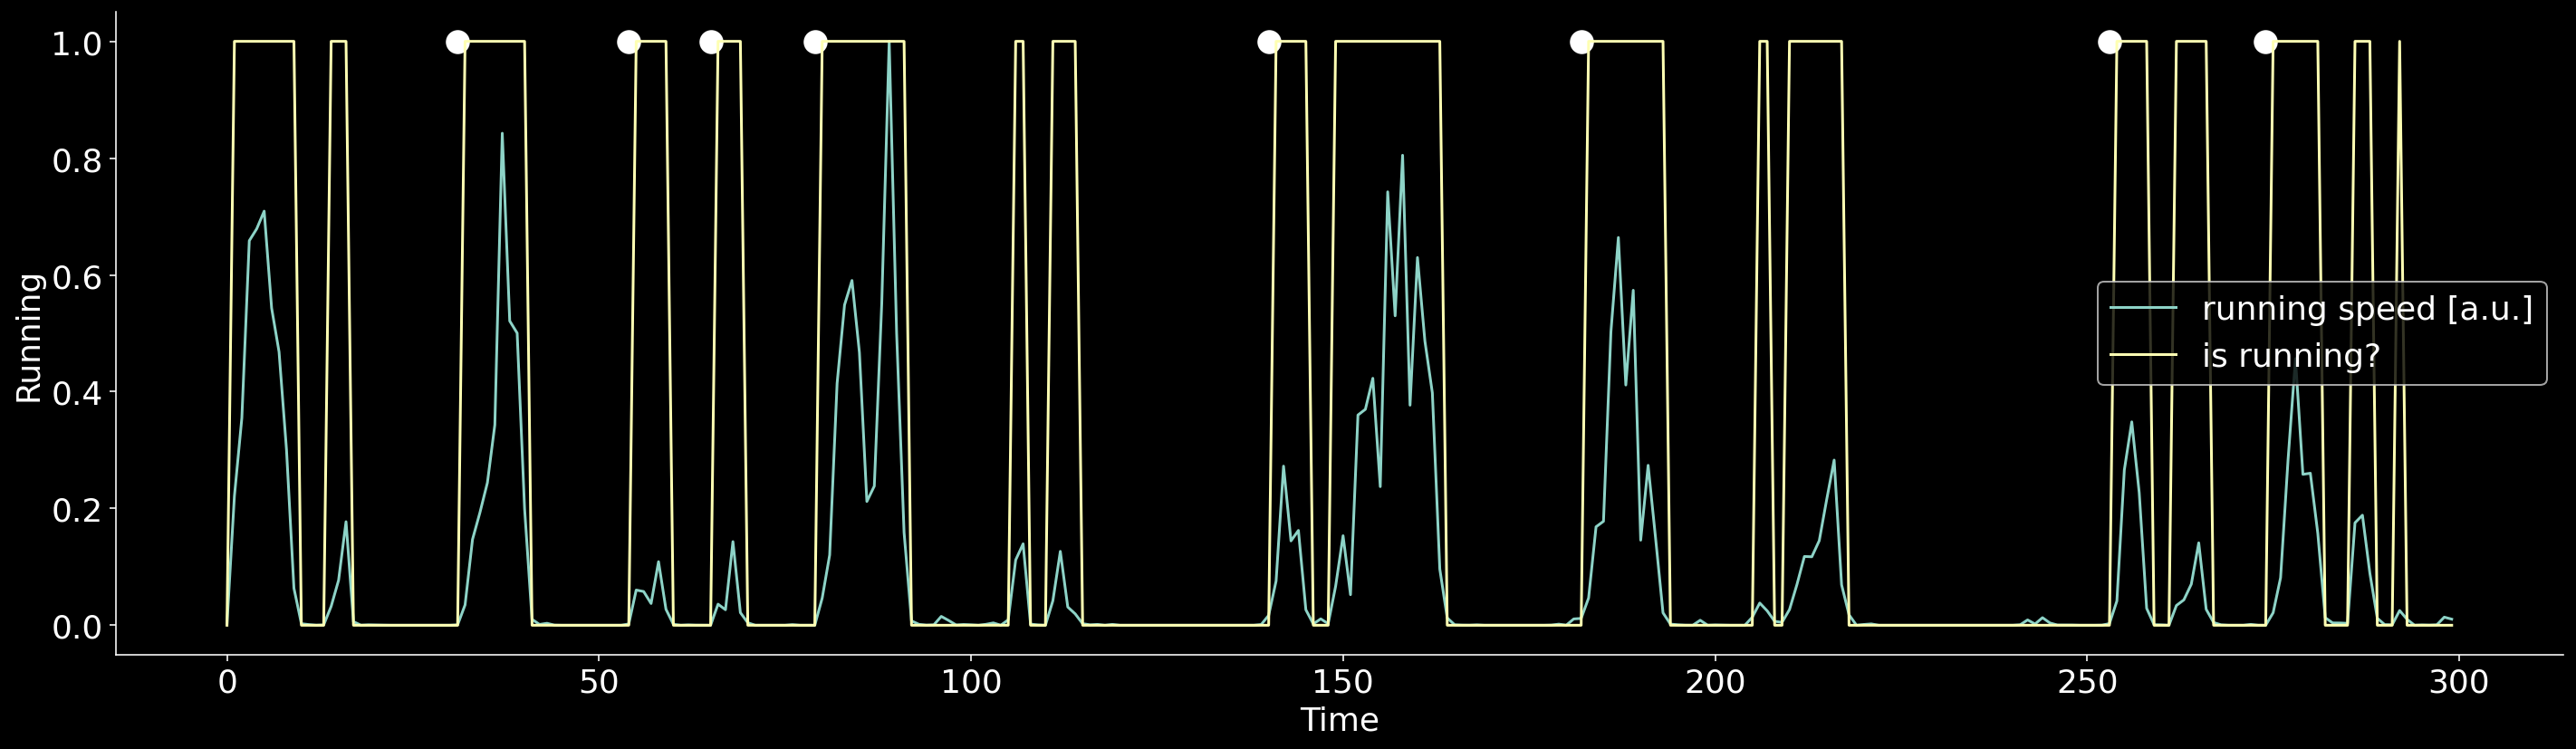

Total # of run starts:  116


In [110]:
stop_len = 300
searchval = [0,0,0,0,1,1,1,1]

idx = [np.s_[i:len(is_run) - len(searchval) +1+i] for i in range(len(searchval))]

x = [is_run[idx[i]] == searchval[i] for i in range(len(searchval))]

x = np.all(x, axis=0)

run_starts = np.where(x)[0] + 4 - 1

#plot
plt.plot(run[:stop_len]/ max(run[:stop_len]), label = "running speed [a.u.]")
plt.plot(is_run[:stop_len], label = "is running?")
plt.scatter(run_starts[run_starts < stop_len], np.repeat(1, len(run_starts[run_starts < stop_len])), color = "white", s = 150)
plt.xlabel("Time")
plt.ylabel("Running")
plt.legend()
plt.show()

print("Total # of run starts: ", len(run_starts))

## splice 

In [111]:
# given a neuron index, and an array of run_starts, output a mean_activity array
def confint_95(a):
  return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

def event_dep_activity(neuron_idx, activity_starts, pad_time_bins):
  neuron = sresp[neuron_idx,:]
  neur_grid = []

  for start in activity_starts:
    x = neuron[start-pad_time_bins:start+1+pad_time_bins]
    x = x-np.mean(x) #normalize
    neur_grid.append(x)

  neur_grid = np.stack(neur_grid, axis=0)

  mean_activity = np.mean(neur_grid, axis=0)
  
  confint = np.array([confint_95(row) for row in neur_grid.T])

  return mean_activity, confint, neur_grid


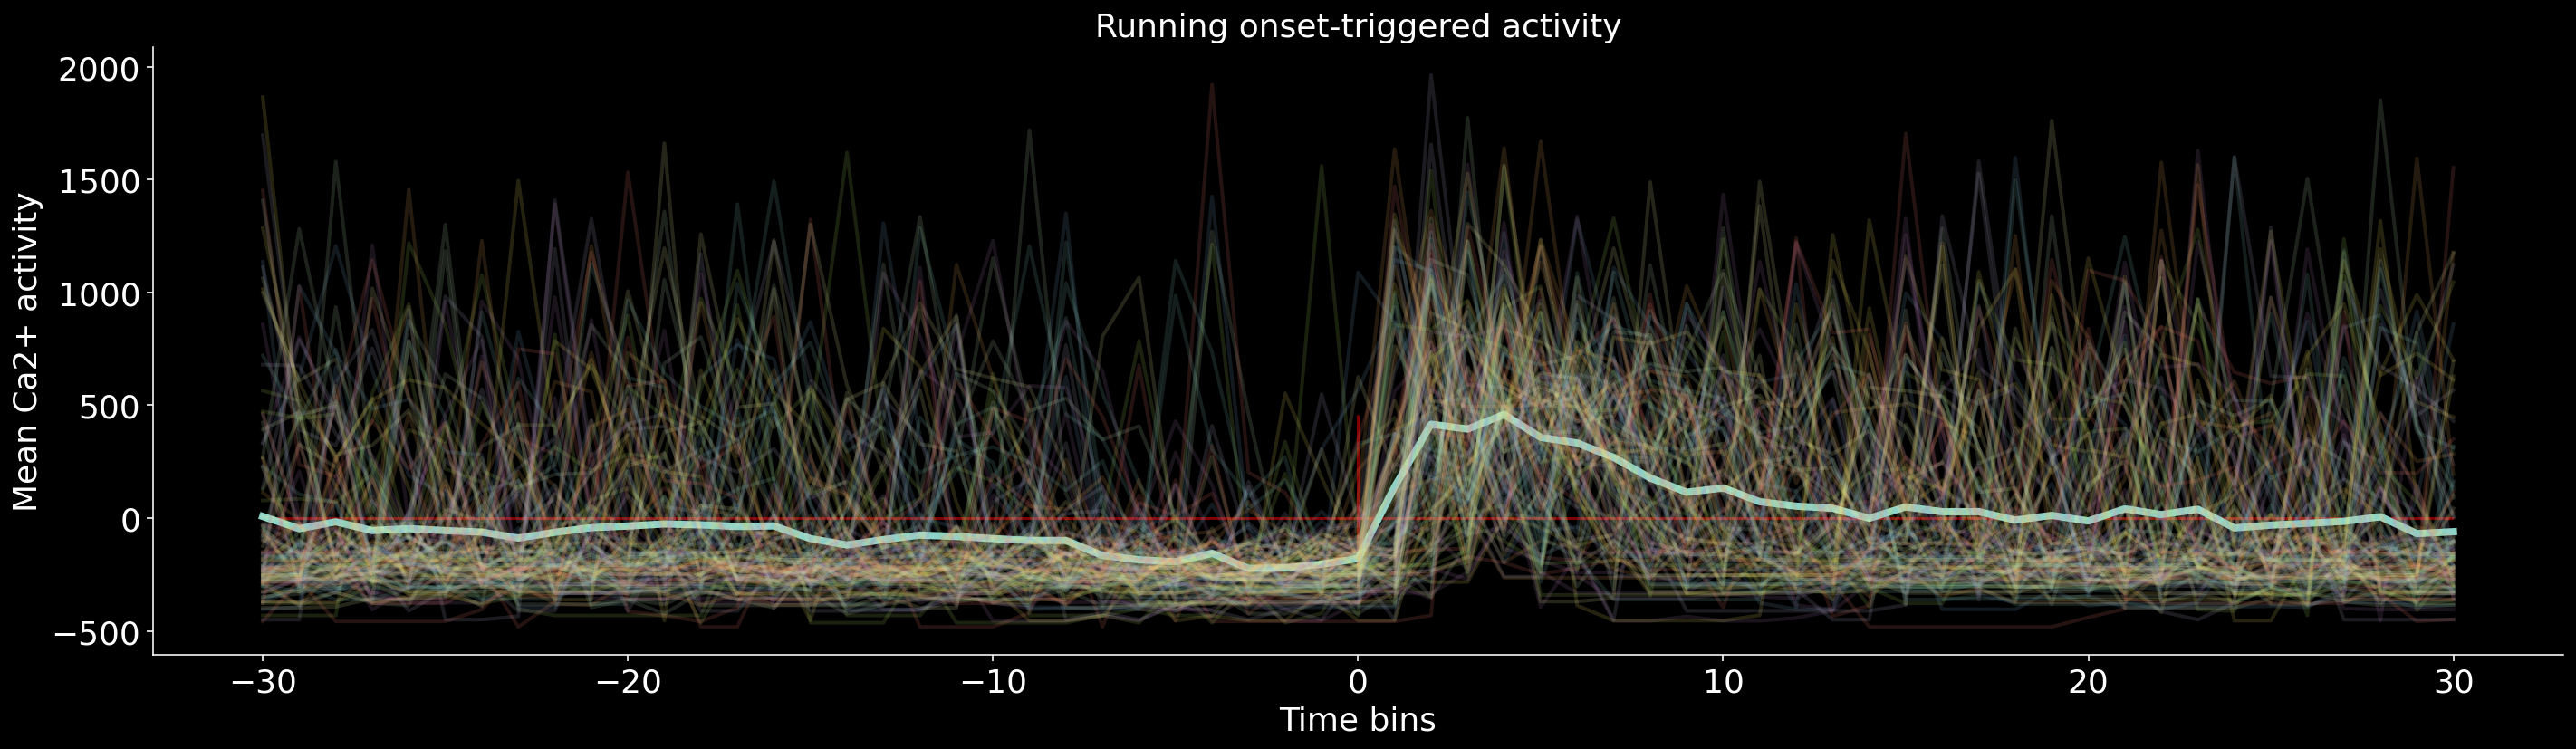

In [112]:
# plot mean activity

pad_time_bins = 30
x_axis = np.arange(-pad_time_bins, pad_time_bins + 1, 1)
x_labs = np.arange(-pad_time_bins, pad_time_bins + 1, 10)

test_mean, test_confint, neur_grid = event_dep_activity(1373, run_starts, pad_time_bins=pad_time_bins)

plt.plot(x_axis, test_mean, linewidth = 4)
for i in range(0, len(neur_grid)):
  plt.plot(x_axis, neur_grid[i], alpha = 0.15, linewidth = 2)
# plt.fill_between(x_axis, 
#                  test_confint[: , 0], test_confint[: , 1],
#                  alpha = 0.2, linewidth = 0.)
plt.title("Running onset-triggered activity")
plt.xlabel("Time bins")
plt.ylabel("Mean Ca2+ activity")
plt.hlines(0, -pad_time_bins, pad_time_bins, color = "red", alpha = 0.5)
plt.vlines(0, min(test_mean), max(test_mean), color = "red", alpha = 0.5)
plt.show()



In [113]:
#load in Di's
idx_HTN_319 = np.load("/content/drive/My Drive/nma_data/idx_HTN_319.npy")
neur_idx = np.array(range(len(idx_HTN_319)))
neur_idx = neur_idx[idx_HTN_319]

print(neur_idx)


[   61    84   190   247   430   750  1206  1259  1269  1274  1280  1282
  1287  1338  1391  1508  1552  1592  1644  2357  2366  2375  2404  2446
  2449  2477  2483  2484  2488  2495  2500  2517  2545  2581  2598  2607
  2671  2690  2699  2715  2716  2748  2753  2769  2801  2829  2846  2850
  2866  3040  3598  3604  3670  3672  3682  3683  3685  3722  3768  3776
  3777  3780  3794  3818  3824  3834  3864  3868  3871  3873  3909  3910
  3932  3946  3970  3976  3989  4000  4032  4053  4071  4113  4202  4311
  4340  4351  4460  4488  4699  4915  4927  4941  4973  4977  4979  4983
  4990  5016  5019  5048  5078  5079  5090  5121  5127  5128  5131  5138
  5148  5175  5181  5239  5310  5314  5319  5345  5349  5351  5353  5392
  5711  5817  5865  6150  6188  6257  6317  6333  6365  6397  6398  6411
  6412  6414  6438  6444  6457  6479  6482  6485  6491  6494  6500  6555
  6582  6587  6589  6592  6602  6603  6626  6629  6635  6640  6671  6741
  6779  6806  6838  6867  6916  6936  7145  7260  7

In [114]:
# make a matrix of these curves
run_onset_grid = []

for idx in neur_idx:
  test_mean, test_confint, neur_grid = event_dep_activity(idx, run_starts, pad_time_bins=pad_time_bins)
  run_onset_grid.append(test_mean)

run_onset_grid = np.stack(run_onset_grid, axis=0)


In [115]:
# save
np.save("/content/drive/My Drive/nma_data/6163622_v6/run_onset/idx_319.npy", neur_idx)
np.save("/content/drive/My Drive/nma_data/6163622_v6/run_onset/run_onset_Ca2+_319.npy", run_onset_grid)



In [116]:
# get mean running speeds
def event_dep_running(run, activity_starts, pad_time_bins):
  run_grid = []

  for start in activity_starts:
    x = run[start-pad_time_bins:start+1+pad_time_bins]
    run_grid.append(x)

  run_grid = np.stack(run_grid, axis=0)

  mean_run = np.mean(run_grid, axis=0)
  
  confint = np.array([confint_95(row) for row in run_grid.T])

  return mean_run, confint, run_grid

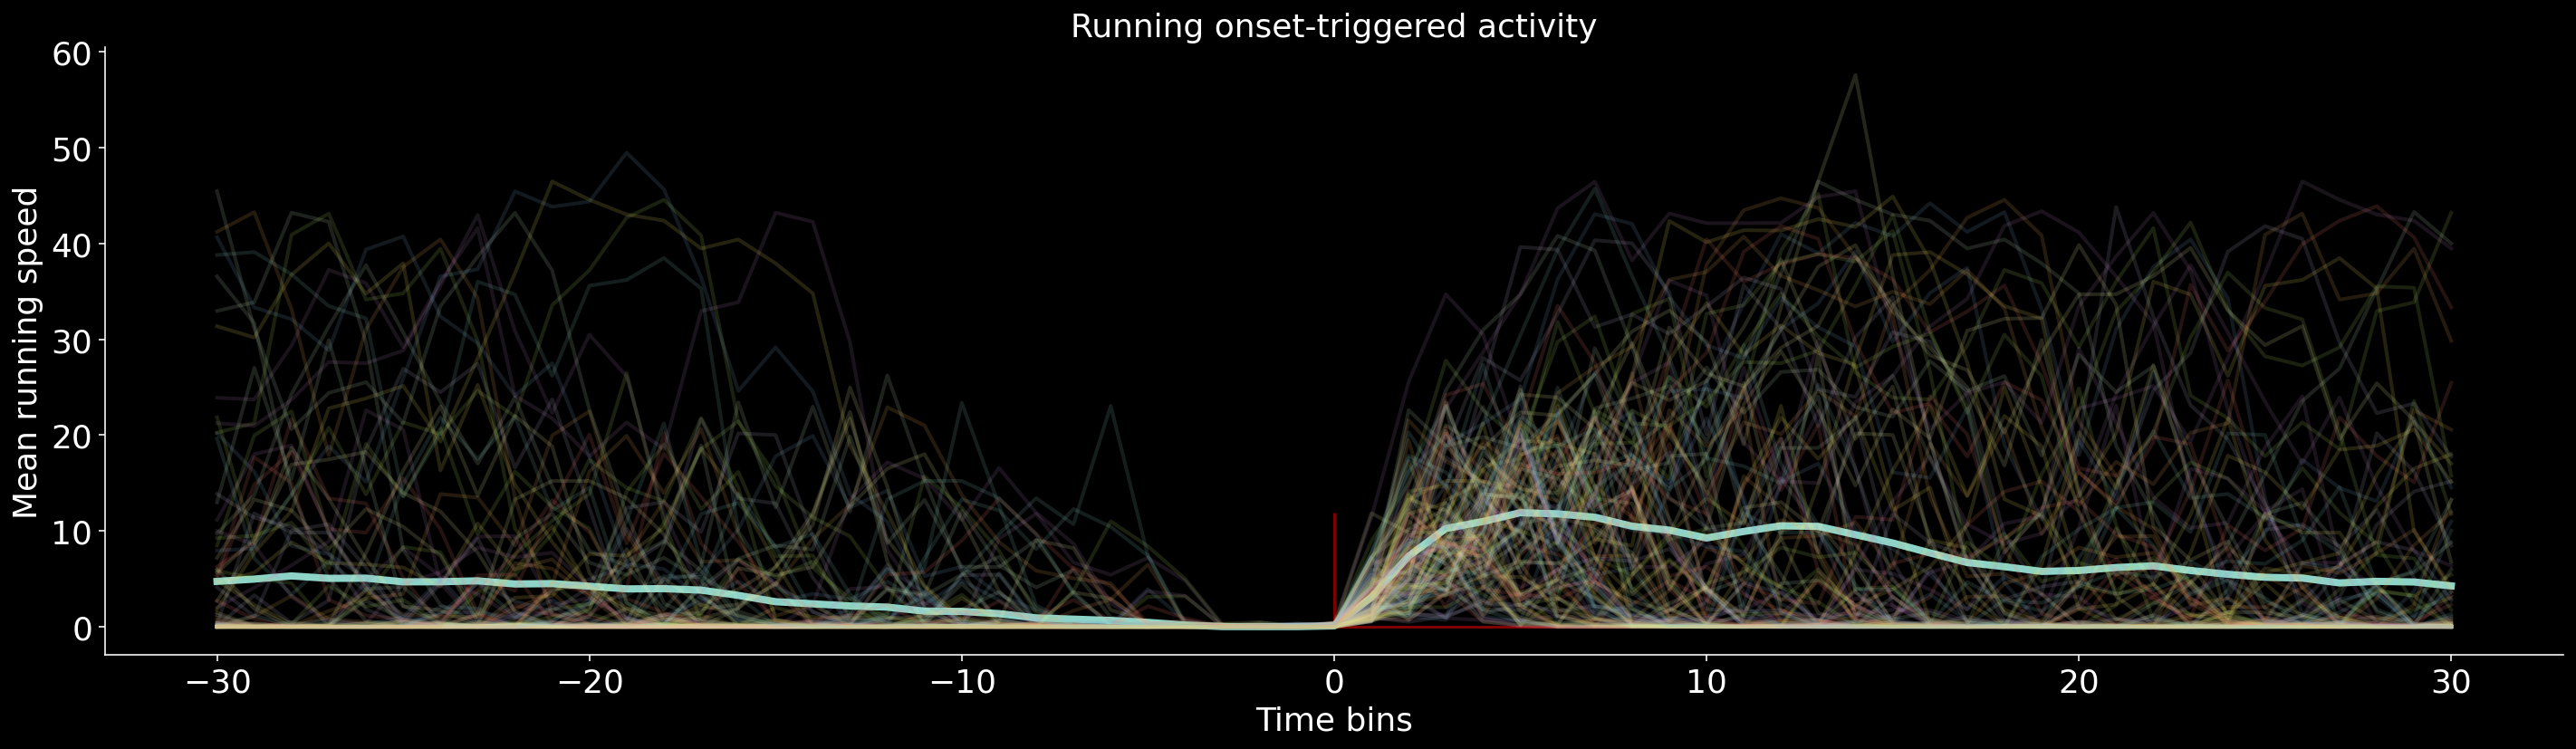

In [117]:
mean_runs, test_confint, run_grid = event_dep_running(run, run_starts, pad_time_bins=pad_time_bins)
np.save("/content/drive/My Drive/nma_data/6163622_v6/run_onset/mean_runs.npy", mean_runs)
np.save("/content/drive/My Drive/nma_data/6163622_v6/run_onset/run_grid.npy", run_grid)

plt.plot(x_axis, mean_runs, linewidth = 4)
for i in range(0, len(run_grid)):
  plt.plot(x_axis, run_grid[i], alpha = 0.15, linewidth = 2)
# plt.fill_between(x_axis, 
#                  test_confint[: , 0], test_confint[: , 1],
#                  alpha = 0.2, linewidth = 0.)
plt.title("Running onset-triggered activity")
plt.xlabel("Time bins")
plt.ylabel("Mean running speed")
plt.hlines(0, -pad_time_bins, pad_time_bins, color = "red", alpha = 0.5)
plt.vlines(0, min(mean_runs), max(mean_runs), color = "red", alpha = 0.5)
plt.show()


In [118]:
#settings
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

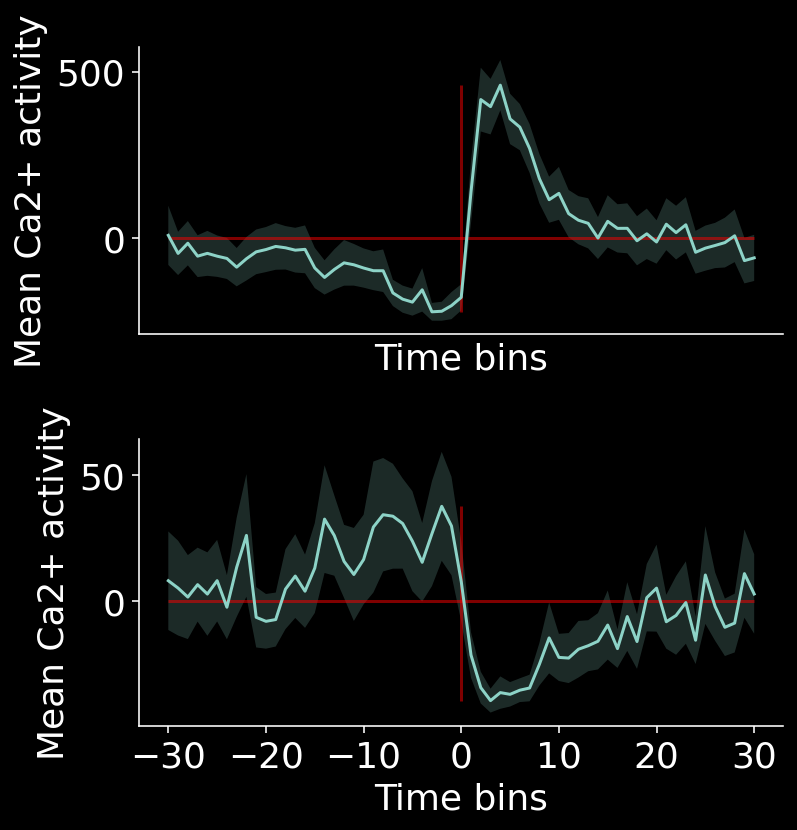

In [119]:
# plot the example neurons for poster

fig, axs = plt.subplots(2,1, figsize=(6,6), edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.1)

test_mean, test_confint, neur_grid = event_dep_activity(1373, run_starts, pad_time_bins=pad_time_bins)

axs[0].plot(x_axis, test_mean)
axs[0].fill_between(x_axis, 
                 test_confint[: , 0], test_confint[: , 1],
                 alpha = 0.2, linewidth = 0.)
axs[0].set_xlabel("Time bins")
axs[0].set_ylabel("Mean Ca2+ activity")
axs[0].get_xaxis().set_ticks([])
axs[0].hlines(0, -pad_time_bins, pad_time_bins, color = "red", alpha = 0.5)
axs[0].vlines(0, min(test_mean), max(test_mean), color = "red", alpha = 0.5)

test_mean, test_confint, neur_grid = event_dep_activity(2963, run_starts, pad_time_bins=pad_time_bins)

axs[1].plot(x_axis, test_mean)
axs[1].fill_between(x_axis, 
                 test_confint[: , 0], test_confint[: , 1],
                 alpha = 0.2, linewidth = 0.)
axs[1].set_xlabel("Time bins")
axs[1].set_ylabel("Mean Ca2+ activity")
axs[1].get_xaxis().set_ticks(x_labs)
axs[1].hlines(0, -pad_time_bins, pad_time_bins, color = "red", alpha = 0.5)
axs[1].vlines(0, min(test_mean), max(test_mean), color = "red", alpha = 0.5)

# fig.savefig("event_triggered.png",dpi=600,transparent=False,bbox_inches="tight")
# files.download("event_triggered.png")

## TO DO: 
- see if the dips before onset are just an artifact of staying still, and our zeroing method
- do some offset-dependent traces
- visualize a bunch of stuff, including a bunch of negatively tuned
- integrate over activity after onset, and compare to before onset. Use this for a ranking?


